#Transformer Applications

Here's the link if you want to test: https://colab.research.google.com/drive/1T-imgQE_EDOYEW4G_TAjQ3WB1w_V38vo?usp=sharing

#**1. Transformer**

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

###**1.1. Transformer-Encoder**

####**Token and Positional Embedding**

In [ ]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

####**Transformer-Encoder Block**

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

####**Transformer-Encoder**

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(
            src_vocab_size, embed_dim, max_length, device
        )
        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                ) for i in range(num_layers)
            ]
        )

    def forward(self, x):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, output, output)
        return output

In [ ]:
batch_size = 32
src_vocab_size = 1000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [ ]:
input = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [ ]:
encoder = TransformerEncoder(
    src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
)

In [ ]:
encoded = encoder(input)

In [ ]:
encoded.shape

torch.Size([32, 100, 200])

###**1.2. Transformer-Decoder**

####**Transformer Decoder Block**

In [ ]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_3 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.dropout_3 = nn.Dropout(p=dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output, _ = self.attn(x, x, x, attn_mask=tgt_mask)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(x + attn_output)

        attn_output, _ = self.cross_attn(
            out_1, enc_output, enc_output, attn_mask=src_mask
        )
        attn_output = self.dropout_2(attn_output)
        out_2 = self.layernorm_2(out_1 + attn_output)

        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout_2(ffn_output)
        out_3 = self.layernorm_2(out_2 + ffn_output)
        return out_3

####**Transformer-Decoder**

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self,
            tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim,
            dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(
            tgt_vocab_size, embed_dim, max_length, device
        )
        self.layers = nn.ModuleList(
            [
                TransformerDecoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                ) for i in range(num_layers)
            ]
        )

    def forward(self, x, enc_output, src_mask, tgt_mask):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, enc_output, src_mask, tgt_mask)
        return output

###**1.3. Transformer**

In [ ]:
class Transformer(nn.Module):
    def __init__(self,
            src_vocab_size, tgt_vocab_size,
            embed_dim, max_length, num_layers, num_heads, ff_dim,
            dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.device = device
        self.encoder = TransformerEncoder(
            src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
        )
        self.decoder = TransformerDecoder(
            tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
        )
        self.fc = nn.Linear(embed_dim, tgt_vocab_size)

    def generate_mask(self, src, tgt):
        src_seq_len = src.shape[1]
        tgt_seq_len = tgt.shape[1]

        src_mask = torch.zeros(
            (src_seq_len, src_seq_len),
            device=self.device).type(torch.bool)

        tgt_mask = (torch.triu(torch.ones(
            (tgt_seq_len, tgt_seq_len),
            device=self.device)
        ) == 1).transpose(0, 1)
        tgt_mask = tgt_mask.float().masked_fill(
            tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        enc_output = self.encoder(src)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

In [ ]:
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [ ]:
model = Transformer(
    src_vocab_size, tgt_vocab_size,
    embed_dim, max_length, num_layers, num_heads, ff_dim
)

In [ ]:
src = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [ ]:
tgt = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [ ]:
prediction = model(src, tgt)

In [ ]:
prediction.shape

torch.Size([128, 100, 2000])

#**2. Text Classification using Transformer-Encoder**

###**2.1. Load Dataset**

In [ ]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35
Receiving objects: 100% (39/39), 186.94 MiB | 37.93 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (11/11), done.


In [ ]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31273.tx

In [ ]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [ ]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [ ]:
train_df

,sentence,label
0,Biết đến quán qa foody với chương_trình ăn thử...,1
1,"Ăn hùi chiều , mà giờ dòm lại hình vẫn còn thè...",1
2,Love_Teen đã bổi sung thêm một tủ putding nhé ...,1
3,"Cơ_quan mình ở Đại_Lộc , đã đến và cảm_nhận đư...",1
4,Mùng 1 lượn_lờ rẽ vào IC Lab ăn kem . Quán nhỏ...,1
...,...,...
29995,"Nghe_nói quán bán bình My_Bottle , mình cũng h...",0
29996,Quán này nằm gần chân cầu Bình_Lợi mới nằm bên...,0
29997,Không_gian ấm_cúng cũng tốt .\n Món ăn khá ngo...,0
29998,"Hôm_qua đi sinh_nhật nhỏ bạn , cả đám ghé đây ...",0


###**2.2. Preprocessing**

**Text Cleaning**

In [ ]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [ ]:
train_df['sentence'] = [preprocess_text(row['sentence']) for index, row in train_df.iterrows()]
valid_df['sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

###**2.3. Representation**

In [ ]:
!pip install -q torchtext==0.16.0

In [ ]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [ ]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [ ]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [ ]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

###**2.4. Dataloader**

In [ ]:
import torch

seq_length = 100

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [ ]:
next(iter(train_dataloader))

(tensor([[ 127,   28,    2,  ...,    0,    0,    0],
         [ 208,   30,   65,  ...,    0,    0,    0],
         [ 127,   38,   17,  ...,    0,    0,    0],
         ...,
         [  46,    2,  329,  ...,    0,    0,    0],
         [   7,   69,  785,  ...,    0,    0,    0],
         [1274,   15,  195,  ...,    0,    0,    0]]),
 tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
         0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
         1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
         0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
         0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
         0, 1, 0, 1, 0, 0, 1, 1]))

In [ ]:
len(train_dataloader)

235

In [ ]:
encoded_sentences, labels = next(iter(train_dataloader))

In [ ]:
encoded_sentences.shape

torch.Size([128, 100])

In [ ]:
labels.shape

torch.Size([128])

###**2.5. Trainer**

In [ ]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

###**2.6. Modeling**

In [ ]:
class TransformerEncoderCls(nn.Module):
    def __init__(self,
                 vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.encoder = TransformerEncoder(
            vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.encoder(x)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [ ]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout=0.1

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

In [ ]:
encoded_sentences.shape

torch.Size([128, 100])

In [ ]:
predictions = model(encoded_sentences)

In [ ]:
predictions.shape

torch.Size([128, 2])

###**2.7. Training**

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  235 batches | accuracy    0.524
| epoch   1 |   100/  235 batches | accuracy    0.573
| epoch   1 |   150/  235 batches | accuracy    0.654
| epoch   1 |   200/  235 batches | accuracy    0.722
-----------------------------------------------------------
| End of epoch   1 | Time: 10.82s | Train Accuracy    0.755 | Train Loss    0.644 | Valid Accuracy    0.750 | Valid Loss    0.540 
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.758
| epoch   2 |   100/  235 batches | accuracy    0.770
| epoch   2 |   150/  235 batches | accuracy    0.786
| epoch   2 |   200/  235 batches | accuracy    0.795
-----------------------------------------------------------
| End of epoch   2 | Time:  7.29s | Train Accuracy    0.796 | Train Loss    0.480 | Valid Accuracy    0.797 | Valid Loss    0.446 
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.802
| epoch   3 

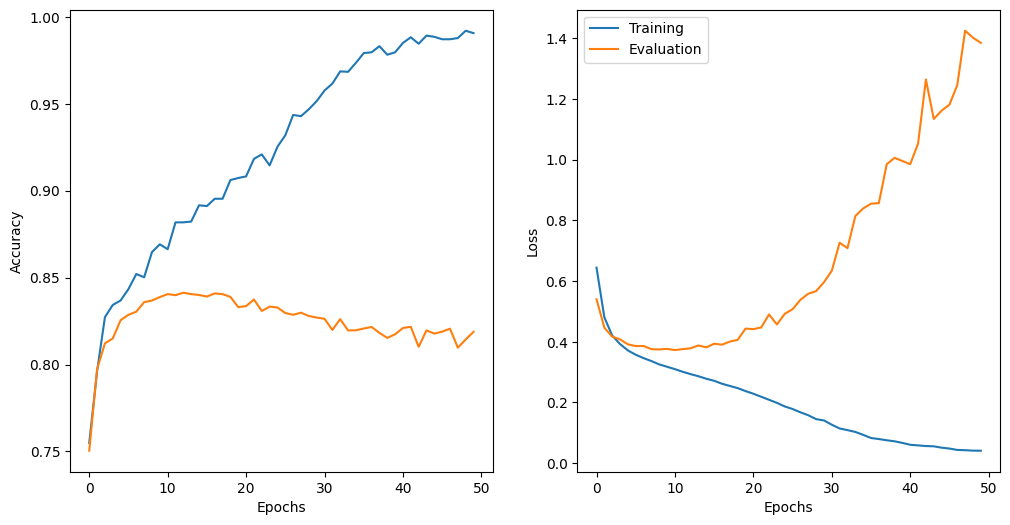

In [ ]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8255, 1.289833526068096)

#**3. Text Classification using BERT**

In [ ]:
!pip install -q -U transformers datasets accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


###**3.1. Load Dataset**

In [ ]:
from datasets import Dataset, DatasetDict

raw_dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'valid': Dataset.from_pandas(valid_df),
    'test': Dataset.from_pandas(test_df)
})

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10000
    })
})

###**3.2. Preprocessing**

In [ ]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
max_seq_length = 100
max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
    # Tokenize the texts

    result = tokenizer(
        examples["sentence"],
        padding="max_length",
        max_length=max_seq_length,
        truncation=True
    )
    result["label"] = examples['label']

    return result

In [ ]:
# Running the preprocessing pipeline on all the datasets
processed_dataset = raw_dataset.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/30000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

###**3.3. Modeling**

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification

num_labels = 2

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task="text-classification"
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

###**3.4. Metric**

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

###**3.5. Trainer**

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="save_model",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

###**3.6. Training**

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.423262,0.809400
2,No log,0.401464,0.824700
3,0.447100,0.392191,0.836700
4,0.447100,0.373473,0.842200
5,0.316700,0.396957,0.840800
6,0.316700,0.416141,0.842200
7,0.245100,0.454328,0.843700
8,0.245100,0.468748,0.845100
9,0.187800,0.486744,0.841400
10,0.187800,0.489360,0.842600


TrainOutput(global_step=2350, training_loss=0.2787000177261677, metrics={'train_runtime': 5266.3379, 'train_samples_per_second': 56.966, 'train_steps_per_second': 0.446, 'total_flos': 1.54166634e+16, 'train_loss': 0.2787000177261677, 'epoch': 10.0})

In [ ]:
trainer.evaluate(processed_dataset["test"])

{'eval_loss': 0.3523184061050415,
 'eval_accuracy': 0.8552,
 'eval_runtime': 58.1311,
 'eval_samples_per_second': 172.025,
 'eval_steps_per_second': 1.359,
 'epoch': 10.0}